In [1]:
import numpy as np
import numpy.random as npr
import scipy.stats as sps
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_pmf(N, p_true, p_observed=None, figsize=(6.5, 2.5)):
    probs = sps.binom.pmf(n=N, k=np.arange(N+1), p=p_true)
    plt.figure(figsize=figsize)
    plt.bar(x=np.arange(N+1), height=probs)
    ymax = probs.max() + 0.005
    plt.vlines(x=N * p_true, ymin=0, ymax=ymax, color='red', linestyles='-')   
    if p_observed:
        plt.vlines(x=N * p_observed, ymin=0, ymax=ymax, color='violet', linestyles='-')
    plt.xlim(0,100)
    plt.xlabel("number of correct predictions, $k$")
    plt.ylabel("probability of $k$")

def print_cdf(N, p_true, p_observed):
    k_observed = N * p_observed
    cdf_at_k_minus1 = 100 * sps.binom.cdf(n=N, p=p_true, k=k_observed)
    print(
        f"There's a {cdf_at_k_minus1:0.1f}% chance of observing "
        f"an empirical accuracy <= {100 * p_observed:0.1f}% when "
        f"{N=} and the true accuracy = {100 * p_true:0.1f}%\n"
    )

# Tales from the Binomial Tail: confidence intervals for balanced accuracy

***Authors:*** *Ted Sandler, Paulina Varshavskaya, Leo Dirac*

## Overview

At Groundlight, we put careful thought into measuring the correctness of our machine learning detectors. In the simplest case, this means measuring detector accuracy. But our customers have vastly different performance measurement needs since our platform allows one to train an ML model for virtually any Yes/No visual question-answering task. A single metric like accuracy is unlikely to provide adequate resolution for all such problems. Some customers might care more about false positive mistakes (precision) than false negative ones (recall), whereas others might care about false negatives.

To provide insight into detector performance for such varied use cases, yet still provide a single-number summary, Groundlight's **accuracy details** view displays a detector's [balanced accuracy](https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score). Balanced accuracy is the average recall across all classes and is the prefered summary metric at Groundlight. For binary problems, this is just the mean of the accuracy on the YESs and the accuracy on the NOs. We like balanced accuracy because it is more intuitive and easier to understand than metrics like the F1 score or AUROC. And many commercially interesting problems are highly imbalanced - that is the answer is almost always NO, with very few YESs, or vice versa. For such problems, standard accuracy is not a good measure because always predicting the most common class will yield high accuracy, but will be useless in practice.

<figure>
    <center>
    <img src="images/binomial-tails/streecar-visible-accuracy-details.png" width="75%" style="padding:30px"/>
    <figcaption>
        Figure 1 - <em>balanced and per-class accuracy with exact 95% confidence intervals.</em>
    </figcaption>
    </center>
</figure>

However, displaying the balanced accuracy alone is still not very informative as we do not always have an ample supply of **ground truth** labeled images to estimate it from. (Ground truth labels are answers to image queries that have been provided by customers or a knowledgeable customer representative, and are therefore guaranteed to be correct.) With only few ground truth labeled images, our estimate of a detector's balanced accuracy may be imprecise. As such, we've found it helpful to quantify and display just how accurate the detector's balanced accuracy estimate is by computing and displaying confidence intervals for the reported balanced accuracy. And this brings us to the subject of this blog post.

At Groundlight, we compute exact confidence intervals to upper and lower bound each detector's balanced accuracy. The detector's accuracy details view (figure 1 above) shows them as colored bars surrounding the reported accuracy number. This blog post describes how we compute these exact confidence intervals using the tails of the binomial distribution, and it also provides associated intuition along with the math.

Unlike the confidence intervals based on the Gaussian distribution which you may be familiar with, confidence intervals based on the binomial tails are exact and always valid, regardless of the number of ground truth labels available. Our exposition largely follows [Langford, 2005](https://jmlr.org/papers/v6/langford05a.html) and we use his "program bound" as a primitive to construct confidence intervals for the balanced accuracy metric.

## Background

To estimate and construct confidence intervals for balanced accuracy, we first need to know how to construct confidence intervals for "plain old" standard accuracy. So we'll start here.

Recall that plain old accuracy is just the fraction of correct predictions that a classifier makes. To define this fraction rigorously, we make the assumption that there's a fixed distribution over the set of possible examples that our classifier might encounter. This distributional assumption helps us talk meaningfully about the classifier's "true accuracy". And to make it clear why it's needed, consider the case that our classifier performs well on daytime images but poorly on nighttime images. If the underlying distribution consists mainly of daytime images, then our classifier's accuracy will be high, but if it's mostly nighttime images, the accuracy will be low. Thus, the classifier's true accuracy is implicitly a function of the distribution of examples it's applied to. We almost never know what this distribution is (in fact, it's mainly a mathematical fiction, but a useful one). But for our classifier to possess something like a Platonic "true accuracy" that is immutable, we assume a distribution over examples that remains static and fixed.

Call this distribution over examples, $D$. Each example in $D$ consists of an image and an associated answer which is a binary label, either YES or NO. Let $\mathcal{X}$ denote the set of all possible images; $\mathcal{Y}$ = { YES, NO } denote the set of possible labels for those images; and let $(x,y) \sim D$ denote the action of sampling an example from $D$. We conceptualize our machine learning classifier as a function, $h$, that maps from the set of images, $\mathcal{X}$ to the set of labels, $\mathcal{Y}$. And we say that $h$ correctly classifies an example $(x,y)$ if $h(x) = y$ and that $h$ misclassifies it otherwise.

Our goal is to construct a confidence inverval for the true but unknown accuracy of $h$, which we define as the probability that $h$ correctly classifies an example drawn from $D$:
$$
 \text{acc}_{D}(h) = \Pr_{(x,y) \sim D}[ \,h(x) = y\, ].
$$

The true accuracy is impossible to compute exactly because $D$ is unknown and the universe of possible images is impossibly large. However, we can estimate it by evaluating $h$ on a finite test set of examples, $S$, which have been [drawn i.i.d.](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables) from $D$. That is,
$$
S = \{ (x_1, y_1), (x_2, y_2), ..., (x_{n}, y_{n}) \}
$$
where $(x_i, y_i) \sim D$ for $i=1,\ldots,n$. The fraction of $S$ that $h$ correctly classifies is called the classifier's empirical accuracy on $S$,
$$
\widehat{\text{acc}}_{S}(h) = \frac{1}{n} \sum_{i=1}^n \mathbf{1}[\, h(x_i) = y_i \,].
$$
The notation, $\mathbf{1}[\, \texttt{condition} \,]$, denotes the indicator function which equals 1 when $\texttt{condition}$ is true and 0 otherwise. So the formula above is just a way of counting the number of examples from $S$ that are correctly classified and dividing by n.

The egg-shaped infographic below depicts the scenario of estimating true accuracy from $h$'s performance on a finite test set of examples. The gray ellipse denotes the full distribution of examples, $D$. Each dot represents a single example whose position is $x$ and whose true label, $y$, is represented by the color - red for YES and blue for NO. The classifier $h$ is represented by the dotted black line. $h$ classifies points to the left of the line as YES (red) and points to the right as NO (blue). Points with light gray circles around them have been sampled to form a test dataset, $S$.

<figure>
    <center>
        <img src="images/binomial-tails/generalization.png" width="350px" style="padding:10px"/>
        <figcaption>
        Figure 2 - <em>true accuracy must be estimated from the classifier's performance on a finite test.</em>
        </figcaption>
    </center>
</figure>

In this case, we got unlucky with our sampled test set because $h$'s empirical accuracy on $S$ looks great, appearing to be 9/9 = 100%. But evaluating $h$ on all examples in $D$ shows that it's true accuracy is much lower, only 24/27 = 89%.

## Test Set Accuracy and Coin Flips

Notice that the problem of determining the true accuracy of a classifier from its performance on a finite test set of examples exactly mirrors the problem of determining the bias of a possibly unfair coin after observing some number of flips. The act of classifying an example corresponds to flipping the coin, and the prediction being correct corresponds to the coin landing heads. (Or tails if you prefer, but we'll stick with heads.)

Usefully, the binomial distribution exactly describes the probability of observing $k$ heads in $N$ independent tosses of a biased coin, where the bias of the coin - that is the propensity of the coin to land heads - is the probability $p$. The binomial distribution's probability mass function (PMF) provides this probability and is defined as
$$
f_{N,p}(k) = {N \choose k} p^k (1 - p)^{N-k}.
$$

The cumulative density function (CDF) sums the PMF over all values from 0 up through $k$ and gives the probability of observing $k$ or fewer heads when $N$ tosses have been made and the coin's bias is $p$,
$$
F_{N,p}(k) = \sum_{j = 0}^k f_{N,p}(k) %{N \choose j} p^{j} (1 - p)^{N-j}.
$$

To help with intuition, here are some plots of the binomial PMF and CDF for *N*=30 and *p*=0.3
<table>
<tr>
    <td><img src="images/binomial-tails/binomial-pmf.png" width=300 /></td>
    <td><img src="images/binomial-tails/binomial-cdf.png" width=300 /></td>
</tr>
</table>

The PMF (above left) looks like a symmetric "bell curve", although this need not be the case as evidenced by the center and right plots below in which the PMF has parameters p=0.15 and p=0.96, respectively. The CDF (above right) is just the cumulative sum of the PMF, and is thus a monotonically increasing function that reaches 1.0 on the right side where the sum of the PMF probabilities must total up to unity.

<table>
<tr>
    <td><img src="images/binomial-tails/different-binomials-pmfs.png" width=950/></td>
</tr>
</table>



## Upper Bounding the True Accuracy from Test Set Performance

Now that we have an understanding of the number of tosses that land heads given a possibly unfair coin and how it mirrors the number of correctly classified examples on a sampled test set, let's consider the problem of determining an upper bound for the true accuracy of a classifier given its performance on a randomly sampled test set.

Imagine that we sample a test set, $S$, of 100 examples from $D$ and that our classifier, $h$, correctly classifies 80 of these 100 examples. Our goal is to upper bound the true accuracy, $\text{acc}_D(h)$, based on the fact that the empirical accuracy, $\widehat{\text{acc}}_S(h)$, is observed to be 80/100 = 80%.

Let's start by considering what would be the case if we used our observed / empirical accuracy of 80% as the upper bound. In the cell below, we plot the PMF of the binomial distribution with parameters N=100 and p=0.80. Here, N is the test set size and p corresponds to the true (but unknown) classifier accuracy. The plot shows that if the true accuracy was in fact 80%, there would be a very good chance of observing an even lower empirical accuracy than what we observed, which was the empirical accuracy of 80%. This fact is represented by the substantial probability mass to the left of the purple vertical line placed at the empirical accuracy point of 80%.

In fact, the CDF of the binomial tells us that there is a 54% chance of seeing an empirical accuracy of 80% **or less** when N=100 and the true accuracy is 80%. And since 54% is quite high, the choice of 80% as an upper bound doesn't appear to very conservative. It would therefore be wise to increase our upper bound if we want it to be an upper bound!

There's a 54.0% chance of observing an empirical accuracy <= 80.0% when N=100 and the true accuracy = 80.0%



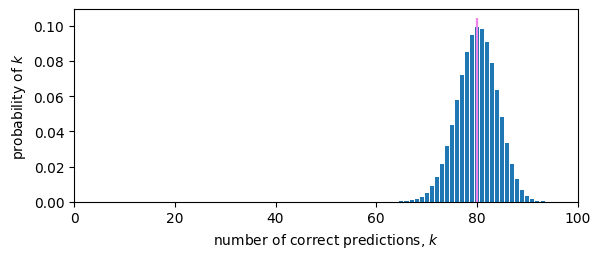

In [5]:
print_cdf(N=100, p_true=0.80, p_observed=0.80)
plot_pmf(N=100, p_true=0.80, p_observed=0.80)

<br>
In contrast, the plot below shows that if the true accuracy were a bit higher, at 83%, we would observe an empirical accuracy of 80% or less on roughy one quarter of test sets sampled. This is shown by the 24.8% probability mass located to the left of the purple line at the 80% empirical accuracy point. The red line is positioned at the hypothesized true accuracy of 83%. Since the chance of observing an empirical accuracy of 80% (or less) when the true accuracy is 83% is roughly one in four, 83% seems like a more conservative upper bound than our initially proposed upper bound of 80%. But still, events with one in four odds are quite likely to be observed, so choosing an even larger upper bound would be wise.

There's a 24.8% chance of observing an empirical accuracy <= 80.0% when N=100 and the true accuracy = 83.0%



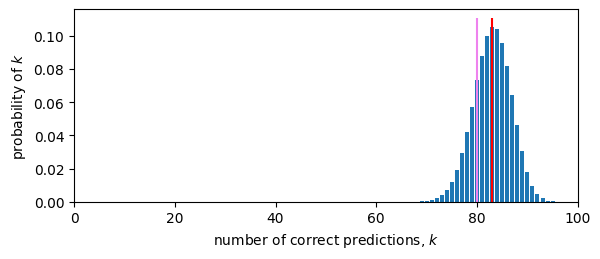

In [6]:
print_cdf(N=100, p_true=0.83, p_observed=0.80)
plot_pmf(N=100, p_true=0.83, p_observed=0.80)

And finally, the next plot below shows that if the true accuracy were in fact 86$\frac{1}{3}$%, an empirical accuracy of 80% or less would occur on only 5% of the test sets sampled. This is evidenced by the even smaller probability mass to left of the purple line at 80% empirical accuracy. Again, the red line is positioned at the true accuracy of 86$\frac{1}{3}$%.

There's a 5.0% chance of observing an empirical accuracy <= 80.0% when N=100 and the true accuracy = 86.3%



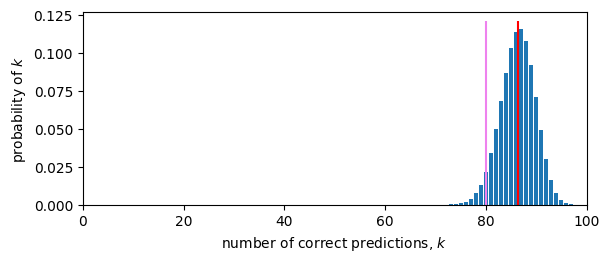

In [7]:
print_cdf(N=100, p_true=0.8633, p_observed=0.80)
plot_pmf(N=100, p_true=0.8633, p_observed=0.80)

As such, we'd be fairly unlucky to observe an empirical accuracy as low as 80% if the true accuracy was 86$\frac{1}{3}$% or higher. And therefore, we can be fairly happy with 86$\frac{1}{3}$% as a choice for our upper bound.

### Constructing a 95% Upper Confidence Bound

The procedure we outlined above, of increasing the hypothesized true accuracy starting from the observed empirical accuracy until exactly 5% of the binomial's probability mass lies to the left of the empirical accuracy, is how we construct an **exact** 95% upper confidence bound on the true accuracy. Remarkably, if we apply this procedure many times to find the 95% accuracy upper confidence bounds for different Groundlight ML models, the obtained upper bounds will in fact be larger than the true accuracies 95% of the time. This last statement is a little subtle and is worth pondering because it is exactly the right way to think about the guarantee provided by a 95% upper confidence bound.

In words, a procedure that produces a 95% upper confidence bound for the true accuracy will output a quantity that is greater than the classifier's true accuracy on 95% of test sets sampled (assuming that test sets are sampled i.i.d. from a fixed distribution and the classifier is not being retrained or otherwise modified).

## Exact Upper Confidence Bounds based on the Binomial CDF

So now that we've gained intuition by running through the procedure used to construct accuracy upper confidence bounds at Groundlight, we are ready for to give the more general and formal treatment which will be helpful when we discuss confidence intervals for balanced accuracy.

First, recall that we defined the binomial cumulative density function (CDF), $F_{N,p}(k)$, which gives the probability of observing $k$ or fewer heads when $N$ tosses have been made and the coin's true bias is $p$. If we let $N$ be the number of test set examples and $k$ be the number of correctly classified test cases, then $k/N$ is our empirical accuracy. The true accuracy $p$ is is of course unknown.

Next, recall that we decided to put exactly 5% of the probability mass to left of the empirical accuracy, and doing so gave us a 95% upper confidence bound. But we needn't have picked 5%. We could have instead put 1% of the lower tail mass to the left of the empirical accuracy, and in doing so we would have obtained a 99% upper confidence bound. The 99% upper bound would be looser than the 95% upper bound, but it would hold on 99% of test sets sampled as opposed to just 95%. The amount of coverage versus tightness of the bound is a trade off that we get to make based on our preferences. We therefore treat it as a parameter that we can set called $\delta$. Above we let $\delta$ be 5% but we could have picked some other number.

We are now ready to formally define exact the upper confidence bound based on the binomial CDF.

**Definition:** a 100(1 - $\delta$)% binomial upper confidence bound, $\bar{p}$, for an observed proportion, $k/N$, is defined as
$$
\bar{p}(N, k, \delta) = \max \{ \, p \,:\, F_{N,p}(k) \ge \delta \,\, \}.
$$

The accuracy upper bound, $\bar{p}$, is the maximum accuracy for which there exists at least $\delta$ probability mass in the lower tail. And this definition exactly mirrors the procedure we used above to find a 95% upper confidence bound on the true accuracy. We had picked $\bar{p}$ to be the max $p$ such that the CDF $F_{N=100,p}(k=80)$ was equal to $\delta$ of 5%. 

We can easily implement the above definition in code. To find the 100(1 - $\delta$)% upper confidence bound when our classifier misclassifies $k$ out of $N$ examples, we use the binomial's CDF to find the largest value of $p$ for which $F_{N,p}(k) \ge \delta$. The binomial CDF function is available in python through the `scipy.stats` module as `binom.cdf`. 
However the binomial CDF isn't directly invertible, so we can't just plug in $\delta$ and get $\bar{p}$ out. Instead we need to search over possible values of $p$ until we find the largest one that satisfies the inequality.  We can do this efficiently using the interval bisection method. The code below implements this.

```python
from scipy.stats import binom

def binomial_upper_bound(N, k, delta):
    """
    Returns a 100*(1 - delta)% upper confidence bound on the accuracy
    of a classifier that correctly classifies k out of N examples.
    """
    def cdf(p):
        return binom.cdf(k, N, p)

    def search(low, high):
        if high - low < 1e-6:
            return low
        mid = (low + high) / 2
        if cdf(mid) >= delta:
            return search(mid, high)
        else:
            return search(low, mid)

    return search(low=k/N, high=1.0)
```



## Lower Confidence Bounds

Referring back to our discussion of coin flips makes it immediately clear how to construct a lower bound on the true accuracy of our classifier. We had likened a correct classification as coin flip that landed heads. But we just as easily could have likened them to a coin flip landing tails. In this case, an upper bound on the probability of tails would correspond to an upper bound on the classifier's error rate, i.e., the true fraction of misclassifiactions.

And since the error rate is just one minus the accuracy, we can immediately obtain a lower bound on the accuracy by upper bounding the error rate and subtracting it from one.

**Definition:** a 100(1 - $\delta$)% binomial lower confidence bound, $\underline{p}$, for the observed proportion, $k/N$, is defined as
$$
\underline{p}(N, k, \delta) \triangleq 1 - \max \{ \, p \,:\, F_{N,p}(N - k) \ge \delta \,\, \}
$$
where $N - k$ is the observed number of tails in the $N$ coin flips.

## Central Confidence Intervals

Now we can derive both upper and lower bounds which hold simultaneously at a given confidence level. To do so, we compute what is called a *central confidence interval*. A 100$\times$(1 - $\delta$)% central confidence interval is computed by running the upper and lower bound procedures with an adjusted confidence level of 100$\times$(1 - $\delta/2$)%.

For example, if we want to compute a 95% central confidence interval, we compute 97.5% lower and upper confidence bounds. This places $\delta/2$ = 2.5% probability mass in each tail, thereby providing 95% coverage in the central region.

Pictorially below, you can see that the 95% central confidence interval (top row) produces wider lower and upper bounds than just using the 95% lower and upper confidence bounds, which is unfortunate. But naively computing the lower and upper bounds at the original confidence level of 95% will sacrifice coverage due to [multiple testing](https://en.wikipedia.org/wiki/Multiple_comparisons_problem). And when we compute central confidence intervals for balanced accuracy in the next section, we will need to do even more to correct for multiple testing.

<figure>
    <center>
        <img src="images/binomial-tails/binomial_confidence_intervals__muted_theme.png" style="height:400px;">
        <figcaption>
            Figure 3 - <em>central confidence interval produces wider bounds to correct for multiple testing</em>
        </figcaption>
    </center>
</figure>


## Confidence Bounds for Balanced Accuracy

A classifier's balanced accuracy is the average of its accuracies on each of the individual classes. For binary classification, this is the average of its accuracies on the positive and negative classes.

To define what we mean by the true balanced accuracy in the binary case, we need to define appropriate distributions on each class. To do this, we decompose $D$ into class conditional distributions, $D^+$ and $D^-$, where
$$
\Pr\left\{ (x,y) \sim D^+ \right\} = \Pr\left\{ (x,y) \sim D \mid y = +1 \right\},
$$
$$
\Pr\left\{ (x,y) \sim D^- \right\} = \Pr\left\{ (x,y) \sim D \mid y = -1 \right\}.
$$

The positive and negative true accuracies are defined with respect to these distributions as
$$
\text{acc}^+(h) = E_{(x,y) \sim D^+} \, \mathbf{1}[ h(x_i) = y_i ]
$$
$$
\text{acc}^-(h) = E_{(x,y) \sim D^-} \, \mathbf{1}[ h(x_i) = y_i ].
$$

True balanced accuracy is defined as the average of these,
$$
\text{acc}_\text{bal}(h) = \frac{\text{acc}^+(h) + \text{acc}^-(h)}{2}.
$$

### Constructing the Bound

With the above definitions in hand, we can now bound the balanced accuracy of our classifier based on its performance on the test set. Let $S$ be our test set, and let
* $N^+$ denote the number of positive examples in $S$
* $N^-$ denote the number of negative examples in $S$
* $k^+$ denote the number of positive examples in $S$ that $h$ correctly classified
* $k^-$ denote the number of negative examples in $S$ that $h$ correctly classified

From these, we can find lower and upper bounds for the positive and negative accuracies based on the binomial CDF.

Denote the lower and upper bounds on positive and negative accuracy, respectively, as:
$$
    \underline{\text{acc}^+}(h)
,~~ \overline{\text{acc}^+}(h)
,~~ \underline{\text{acc}^-}(h)
,~~ \overline{\text{acc}^-}(h).
$$

To find a 100(1 - $\delta$)% confidence interval for $\text{acc}_\text{bal}(h)$, we compute them as
$$
\underline{\text{acc}^+}(h) = \underline{p}(N^+, k^+, \delta/4)
~~ \text{ and } ~~
\overline{\text{acc}^+}(h) = \overline{p}(N^+, k^+, \delta/4)
$$
$$
\underline{\text{acc}^-}(h) = \underline{p}(N^-, k^-, \delta/4)
~~ \text{ and } ~~
\overline{\text{acc}^-}(h) = \overline{p}(N^-, k^-, \delta/4)
$$
Importantly, we use the adjusted delta value of $\delta/4$ to account for mulitple testing. That is, if our original $\delta$ was 5%, we now run our bounding procedures with an adjusted $\delta =1.25\%$.

By our bound selection procedure, each of the positive and negative lower and upper bounds fails to hold with probability $\delta/4$. The union bound in **appendix A** tells us that the probability that at least one of these four bounds fails is less than the sum of the probabilities that each fails to hold, i.e., $4\cdot(\delta/4) = \delta$. Thus the probability that none of the bounds fails is at least $1 - \delta$, as required.

Finally, from these quantities, we obtain exact lower and upper bounds for balanced accuracy by averaging the respective lower and upper bounds:
$$
\underline{\text{acc}_\text{bal}}(h) = (1/2) \left(
\underline{\text{acc}^+}(h) + \underline{\text{acc}^-}(h)
\right)
$$
$$
\overline{\text{acc}_\text{bal}}(h) = (1/2) \left(
\overline{\text{acc}^+}(h) + \overline{\text{acc}^-}(h)
\right)
$$

Pictorially below, we can see how the averaged bounds contain the true balanced accuracy.

<figure>
    <center>
    <img src="images/binomial-tails/balanced-accuracy-bound.png" width="500" style="padding:20px"/>
    </center>
</figure>

## Comparison with intervals based on the Normal approximation

The main benefit of using bounds derived from the binomial CDF is that they are exact and contain the true accuracy exactly the desired fraction of the time.

Let's compare this with the more commonly used bounds based on approximating the binomial with a normal distribution. The motivation for the normal approximation comes from the central limit theorem, and states that for a binomial distribution with parameters $N$ and $p$, the distribution of the empirical estimate, $\hat{p} = k/N$, converges to a normal distribution as the sample size, $N$, goes to infinity,
$$
\hat{p} \stackrel{d}{\longrightarrow} \mathcal{N}\left(p, \frac{p(1-p)}{N}\right).
$$

This motivates the use of the traditional $\pm 2\hat{\sigma}$ confidence interval in which one reports
$$
\Pr\left\{ | p - \hat{p} | \le 2\sigma \right\} \ge 95\%
~ ~ ~ \text{where} ~ ~ ~
\hat{\sigma} = \sqrt{
  \frac{ \hat{p}(1-\hat{p}) }{N}
}.
$$

But this interval poorly approximates the sampling distribution of $\hat{p}$ when $p$ is close to zero or one. For instance, if we observe zero errors on the test set, then $\hat{p}$ will equal one (100% empirical accuracy). The estimated standard deviation, $\hat{\sigma}$, will be zero, and therefore the estimated lower bound will equal the empirical accuracy of 100%, which is clearly not believable.

Moreover, since we want classifiers that have close to 100% accuracy, the regime in which $p$ is close to one is exactly the regime that our customers care about. Thus, the exact confidence intervals based on the binomial CDF are far more accurate in practice than those based on the normal approximation.

## Conclusion

At Groundlight, we put a lot of thought and effort into assessing the performance of our customers' ML models so that customers know how well their detectors are working.

Here we've taken you through a detailed tour of the methods we use to estimate lower and upper bounds for our preferred summary metric, balanced accuracy. The bounds are exact and hold no matter how many test examples are available. Hopefully this tour has been useful and enlightening. If you are interested in reading further about the methods described here, see the references below as well as the brief appendices.

## References

[\[Langford, 2005\]](https://jmlr.org/papers/v6/langford05a.html) *Tutorial on Practical Prediction Theory for Classification*. Journal of Machine Learning Research 6 (2005) 273–306.

[\[Brodersen et al., 2010\]](https://ieeexplore.ieee.org/document/5597285) *The balanced accuracy and its posterior distribution*. Proceedings of the 20th International Conference on Pattern Recognition, 3121-24.

### Appendix A - the union bound

Recall that the union bound states that for a collection of events, $A_1, A_2, \ldots, A_n$, the probability that at least one of them occurs is less than the sum of the probabilities that each of them occurs:
$$\Pr\left\{ \cup_{i=1}^n A_i \right\} \le \sum_{i=1}^n \Pr(A_i).$$

Pictorially, the union bound is understood from the image below which shows that area of the union of the regions is no greater than the sum of the regions' areas.

<figure>
    <center>
    <img src="images/binomial-tails/union-bound.png" width="350" />
    <figcaption>
        Figure 4 - <em>Visualizing the union bound. The area of each region $A_i$ corresponds to the probability that event $A_i$ occurs.</em>
    </figcaption>
    </center>
</figure>


### Appendix B - interpretation of confidence intervals

The semantics around frequentist confidence intervals is subtle and confusing. The construction of a 95% upper confidence bound does **NOT** imply there is a 95% probability that the true accuracy is less than the bound. It only guarantees that the true accuracy is less than the upper bound in about 95% of the cases that we run the the upper confidence bound procedure (assuming we run the procedure many many times). For each individual case, the true accuracy is either greater than or less than the bound, and thus is less than the bound with probability one or zero (we just don't know which).

If you instead want these conditional semantics, you need to use Bayesian credible intervals. See [Brodersen et al., 2010](https://ieeexplore.ieee.org/document/5597285) for a nice derivation.